## import and path define

In [ ]:
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
from torch.utils.data import Dataset
from google.colab import drive
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import random
import datetime


Fri Jan 29 04:33:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mounted Drive if using Colab; otherwise, your local path
root = "drive/My Drive/Colab_Notebooks/Leeds_study/Aritificial_Intelligence/coursework2/data/Flickr8k/"
model_path = root + "models/"
vocab_file = root + "vocab.object.pyobj"
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---
numpy_loss_dir = root
token_file = "Flickr8k.token.txt"

## Text prepare

In [ ]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines
lines = read_lines(caption_dir + token_file)
print(lines[:5])
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1
    def delete_word(self, word):
        if word in self.word2idx:
            current_idx = self.word2idx[word]
            self.word2idx.pop(word)
            self.idx2word.pop(current_idx)
            # Increment the ID for the next word
    def translate_idx(self, idx):
        return self.idx2word[idx] # transfer the index to real word 
    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)
vocab = Vocabulary()
vocabtemp = Vocabulary()
word_counter = np.zeros(8840)
for mix_sentence in lines:
  sentence = mix_sentence.split('#')[1]
  sentence = sentence.split('\t')
  words = sentence[1].split(' ')
  words.pop(len(words)-1)
  if ("." in words):
    words.remove(".")
  if ("," in words):
    words.remove(",")
  for word in words:
    word = word.lower()
    vocabtemp.add_word(word)
    indx = vocabtemp(word)
    word_counter[indx] +=1
print(len(word_counter))
print(len(vocabtemp))
print(word_counter[1000:1100])
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')
for l in range(len(vocabtemp)):
  if word_counter[l]>3:
    vocab.add_word(vocabtemp.translate_idx(l))
print(len(vocab))

import pickle
f = open(vocab_file, 'wb')
pickle.dump(vocab, f)
f.close()

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .', '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']
8840
8840
[  5.  10.  38. 291. 121.   3.  26.   7.  13.  15. 103.  93.   7.  20.
  65.  25.   1.   2.   3.  38.  20.   4.  57.   7.   1.   6.   2.   5.
   1.   4.   2.  38.  67.   5.  23.   5.  11.  37.   7.  16.  30.  85.
  29. 153. 118.   4.  10. 315.   1.   1.  17.  88.  16.  16. 130.   2.
   2.  18.   6.  49.  33.  59.  57.  26.  62.  63.  42.  34.  26.  85.
   5.  67.   1.   2.   1.   3.   2.   5. 104.  25. 165.  36.  29.   1.
   7.  47.   4.  15.   9.  22.  14.  12.  19. 131.  30.   9.   9.  21.
   7.   1.]
3411


## Dataset and loaders for training



In [ ]:
def get_meta(lines):
    """ Fetches the meta data for all the images and assigns labels.
    """
    image_ids, cleaned_captions = [], []
    for line in lines:
      mix_line0 = line.split('#')
      mix_line1 = mix_line0[0].split('.jpg')
      mix_sentence = mix_line0[1].split('\t')
      image_ids.append(mix_line1[0])
      cleaned_captions.append(mix_sentence[1].lower())
                
    return image_ids, cleaned_captions
import pandas as pd
image_ids, cleaned_captions = get_meta(lines)

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])
print(data_df.head(n=5))

                image_id  ...                                            caption
0  1000268201_693b08cb0e  ...  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e  ...              a girl going into a wooden building .
2  1000268201_693b08cb0e  ...   a little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e  ...  a little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e  ...  a little girl in a pink dress going into a woo...

[5 rows x 3 columns]


In [ ]:
from PIL import Image
import cv2
from nltk import tokenize
class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index].lower()
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        for token in tokens:
          indextemp = vocab(token)
          if(indextemp != 3):
            caption.extend([indextemp])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

In [ ]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)# labda is the function to suffle the data
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths
# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

## DataLoader

In [ ]:
unit_size = 5

train_split = 0.90 # Defines the ratio of train/test data.

test_split = 1 - train_split
train_size = unit_size * round(len(data_df)*train_split / unit_size)

test_size = unit_size * round(len(data_df)*test_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[train_size:].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)
train_loader = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=64, 
  shuffle=True,
  num_workers=0,
  collate_fn=caption_collate_fn
)
test_loader = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=5, 
  shuffle=False,
  num_workers=0,
  collate_fn=caption_collate_fn
)
print(train_loader.__len__())
print(test_loader.__len__())


633
809


## Encoder and decoder models

In [ ]:


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()

        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.ft = nn.Flatten() 


    def forward(self, out):
      with torch.no_grad():
        out = self.resnet(out)
      out = self.ft(out)
      out =  self.linear(out)
      out = self.bn(out)

      return out


class DecoderLTSM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderLTSM, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_size)

        self.lstm = nn.LSTM(embed_size, hidden_size,batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


Set training parameters.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 300
init_epochs = 0

cuda


Initialize the models and set the learning parameters.

## Training the model

The loop to train the model. Feel free to put this in a function if you prefer.

In [ ]:
# Train the models
def train_model(encoder,decoder,criterion,optimizer,model_type):
  total_step = len(train_loader)
  loss_summarize = []
  for epoch in range(init_epochs, num_epochs):
    each_epoch_loss = []
    starttime = endtime = datetime.datetime.now()
    for i, (images, captions, lengths) in enumerate(train_loader):
      # Set mini-batch dataset
      images = images.to(device)
      captions = captions.to(device)
      # Packed as well as we'll compare to the decoder outputs
      targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

      # Forward, backward and optimize
      features = encoder(images)
      outputs = decoder(features, captions, lengths)

      loss = criterion(outputs, targets)
      
      # Zero gradients for both networks
      decoder.zero_grad()
      encoder.zero_grad()
      loss.backward()
      optimizer.step()

      # # Print log info
      if i % log_step == 0:
        endtime = datetime.datetime.now()
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}， Time comsumption:{}'.format(epoch+1, num_epochs, i, total_step, loss.item(), endtime-starttime))
        starttime = endtime
        each_epoch_loss.append(loss.item())
    torch.save(decoder.state_dict(), model_path + model_type+'-decoder-epoch_{}.ckpt'.format(epoch+1))
    torch.save(encoder.state_dict(), model_path + model_type+'-encoder-epoch_{}.ckpt'.format(epoch+1))
    loss_summarize.append(each_epoch_loss)

Epoch [1/5], Step [0/633], Loss: 8.1395， Time comsumption:0:00:00.810930
Epoch [1/5], Step [10/633], Loss: 5.7023， Time comsumption:0:00:07.705896
Epoch [1/5], Step [20/633], Loss: 5.1012， Time comsumption:0:00:07.558586
Epoch [1/5], Step [30/633], Loss: 4.9195， Time comsumption:0:00:07.635514
Epoch [1/5], Step [40/633], Loss: 4.5260， Time comsumption:0:00:07.550294
Epoch [1/5], Step [50/633], Loss: 4.2364， Time comsumption:0:00:07.510078
Epoch [1/5], Step [60/633], Loss: 4.3101， Time comsumption:0:00:07.455038
Epoch [1/5], Step [70/633], Loss: 3.9059， Time comsumption:0:00:07.512451
Epoch [1/5], Step [80/633], Loss: 3.8883， Time comsumption:0:00:07.578344
Epoch [1/5], Step [90/633], Loss: 3.8437， Time comsumption:0:00:07.512611
Epoch [1/5], Step [100/633], Loss: 3.8696， Time comsumption:0:00:07.542756
Epoch [1/5], Step [110/633], Loss: 3.5341， Time comsumption:0:00:07.485036
Epoch [1/5], Step [120/633], Loss: 3.5912， Time comsumption:0:00:07.543486
Epoch [1/5], Step [130/633], Loss: 3

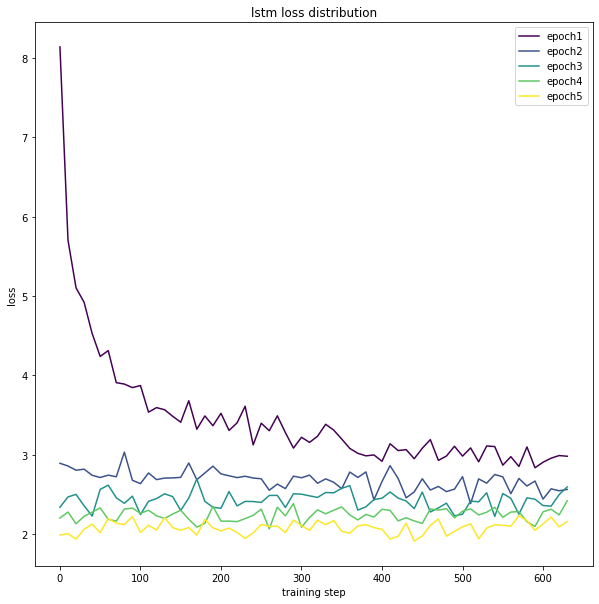

In [ ]:
# Build the LSTM models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderLTSM(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)
model_type = "lstm"
train_model(encoder,decoder,criterion,optimizer,model_type)